> ### EEE6503-01: Computer Vision

# Final Project: Domain Generalization

**<div style="text-align: right"> Due date: Dec 17th, 2024. </div>** 
**<div style="text-align: right"> Please upload your file @ learnus by 11:00 PM. </div>** 

### *Assignment Instructions:*
1. Write a program implementing a particular algorithm to solve a given problem.
2. You can use both Korean and English for your report.
3. **Analyze the algorithm, theoretically and empirically.** 
4. **Report your results.**   

<h2><span style="color:blue">Group 6</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-11-14 17:25:51.640459


The objective of this assignment is to address the domain generalization problem in neural networks.

In [2]:
# You may change the values below.
team_id = '000' # your team id - should be a three-digit number
root_dir = './PACS' # directory to the dataset
lr = 0.0001 # learning rate
step_size = 7 # scheduler step size (if used)

# You must not change the values below.
num_epochs = 10 # number of epochs
image_size = 64 # input image size
batch_size = 32 # batch size for training
model_name = f'{team_id}_model.pth' # model name
TEST_MODE = False # test mode -- evaluation for TAs

In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm

import random
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def set_seed(seed=42):
    # Set the seed for random number generation in Python
    random.seed(seed)
    
    # Set the seed for numpy's random number generation
    np.random.seed(seed)
    
    # Set the seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Ensure that operations are deterministic on GPU (if using CUDA)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage:
set_seed(42)

In [4]:
class PACSDataset(Dataset):
	def __init__(self, root_dir, domain, transform=None):
		"""
		Args:
			root_dir (string): Directory with all the images.
			domains (list): Containing domains of interest, with element choices: 
				['photo', 'art_painting', 'cartoon', 'sketch'].
			transform (callable, optional): Optional transform to be applied on a sample.
		"""        
		self.root_dir = root_dir
		self.domain = domain
		self.transform = transform

		self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
		self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

		self.images = []
		self.labels = []

		# Load images and labels
		domain_dir = os.path.join(self.root_dir, self.domain)
		for cls_name in self.classes:
			cls_dir = os.path.join(domain_dir, cls_name)
			image_files = [f for f in os.listdir(cls_dir) if f.lower().endswith('.jpg')]

			for img_name in image_files:
				self.images.append(os.path.join(cls_dir, img_name))
				self.labels.append(self.class_to_idx[cls_name])

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		img_path = self.images[idx]
		image = Image.open(img_path).convert('RGB')
		label = self.labels[idx]

		if self.transform:
			image = self.transform(image)

		return image, label

In [5]:
# Define transforms
transform_train = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
	])

transform_test = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])

# Create datasets
dataset_train = ConcatDataset([
	PACSDataset(root_dir, 'cartoon', transform=transform_train),
	PACSDataset(root_dir, 'art_painting', transform=transform_train),
	PACSDataset(root_dir, 'sketch', transform=transform_train),
	])

dataset_test = PACSDataset(root_dir, 'photo', transform=transform_test)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [6]:
# Let's visualize some images from the training set

import matplotlib.pyplot as plt
import numpy as np

def visualize_example_images(root_dir, domain):
	assert domain in ['art_painting', 'sketch', 'cartoon']

	def denormalize(tensor):
		"""Denormalize the image tensor for visualization"""
		mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
		std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
		return tensor * std + mean
	
 	# Create dataset
	dataset = PACSDataset(root_dir=root_dir, domain=domain, transform=transform_test)

	# Create a figure with subplots for each class
	fig, axs = plt.subplots(1, 7, figsize=(15, 3))
	fig.suptitle('Sample Images from Each Category')

	# For each class
	for i, class_name in enumerate(dataset.classes):
		# Find first image of this class
		for idx in range(len(dataset)):
			if dataset.labels[idx] == i:
				image, _ = dataset[idx]
				
				# Denormalize the image
				image = denormalize(image)
				
				# Convert to numpy and transpose for plotting
				image = image.numpy().transpose(1, 2, 0)
				
				# Clip values to [0, 1] range
				image = np.clip(image, 0, 1)
				
				# Plot
				axs[i].imshow(image)
				axs[i].set_title(class_name)
				axs[i].axis('off')
				break

	plt.tight_layout()
	plt.show()

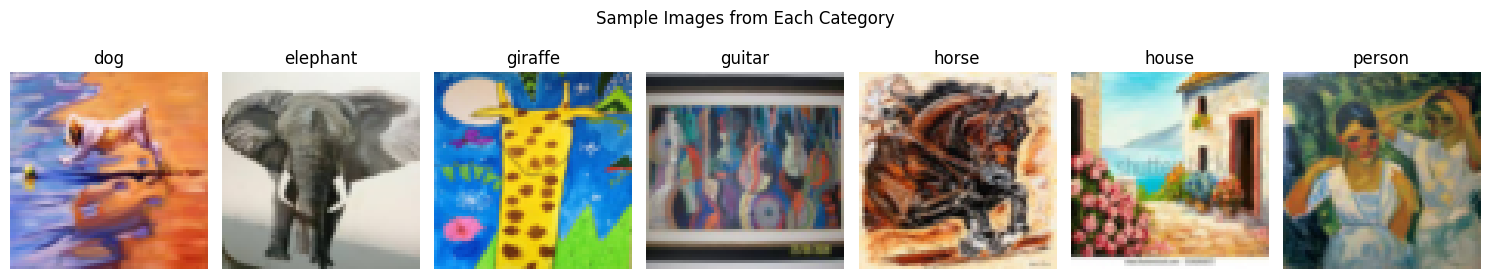

In [7]:
visualize_example_images(root_dir, 'art_painting')

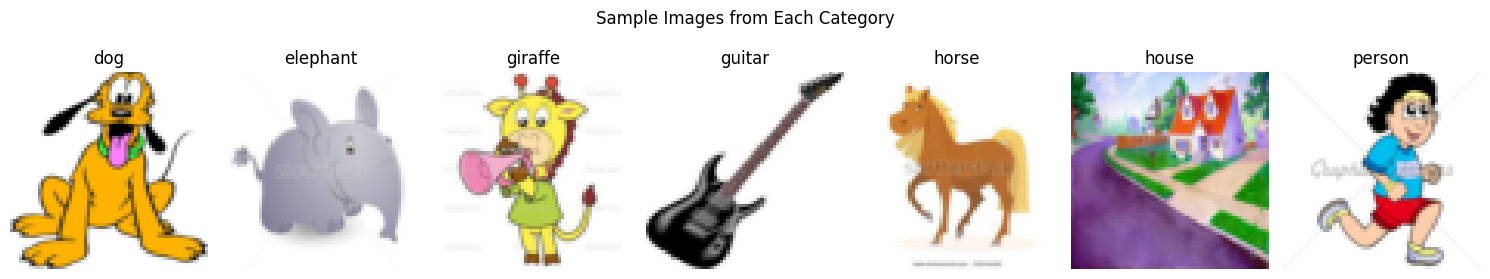

In [8]:
visualize_example_images(root_dir, 'cartoon')

In [9]:
# Load ResNet50 model pre-trained on ImageNet
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the last fully connected layer for 7 classes (PACS has 7 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

In [10]:
# Instantiate loss, optimizer, and scheduler
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

# Loss with Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Scheduler for Cosine Annealing with Warm Restarts
# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

Epoch 1/10: 100%|██████████| 138/138 [00:07<00:00, 18.82it/s]


Epoch [1/10], Loss: 1.1974, Test Accuracy: 77.60%, Learning Rate: 0.000300


Epoch 2/10: 100%|██████████| 138/138 [00:07<00:00, 17.65it/s]


Epoch [2/10], Loss: 0.7562, Test Accuracy: 79.28%, Learning Rate: 0.000300


Epoch 3/10: 100%|██████████| 138/138 [00:07<00:00, 19.11it/s]


Epoch [3/10], Loss: 0.6032, Test Accuracy: 81.02%, Learning Rate: 0.000300


Epoch 4/10: 100%|██████████| 138/138 [00:06<00:00, 20.23it/s]


Epoch [4/10], Loss: 0.5495, Test Accuracy: 84.85%, Learning Rate: 0.000300


Epoch 5/10: 100%|██████████| 138/138 [00:06<00:00, 20.79it/s]


Epoch [5/10], Loss: 0.5285, Test Accuracy: 81.80%, Learning Rate: 0.000300


Epoch 6/10: 100%|██████████| 138/138 [00:06<00:00, 20.82it/s]


Epoch [6/10], Loss: 0.5052, Test Accuracy: 81.14%, Learning Rate: 0.000300


Epoch 7/10: 100%|██████████| 138/138 [00:06<00:00, 20.84it/s]


Epoch [7/10], Loss: 0.5020, Test Accuracy: 80.66%, Learning Rate: 0.000030


Epoch 8/10: 100%|██████████| 138/138 [00:06<00:00, 20.87it/s]


Epoch [8/10], Loss: 0.4801, Test Accuracy: 81.50%, Learning Rate: 0.000030


Epoch 9/10: 100%|██████████| 138/138 [00:06<00:00, 20.85it/s]


Epoch [9/10], Loss: 0.4677, Test Accuracy: 81.26%, Learning Rate: 0.000030


Epoch 10/10: 100%|██████████| 138/138 [00:06<00:00, 20.86it/s]


Epoch [10/10], Loss: 0.4631, Test Accuracy: 82.22%, Learning Rate: 0.000030
Finished Training


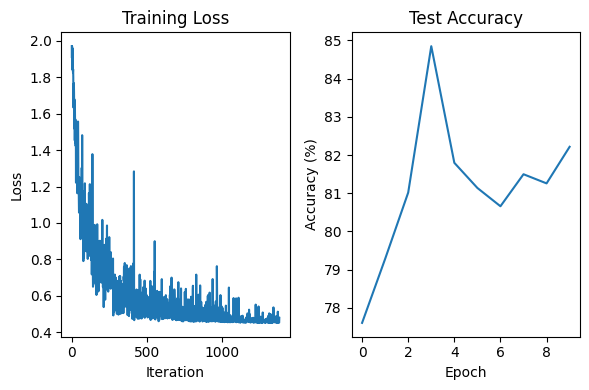

In [11]:
if not TEST_MODE:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	model = model.to(device)

	# Lists to store loss and accuracy values
	train_losses = []
	test_accuracies = []

	for epoch in range(num_epochs):
		model.train()
		running_loss = 0.0
		correct = 0
		total = 0

		for i, (inputs, labels) in enumerate(tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}')):
			inputs, labels = inputs.to(device), labels.to(device)

			optimizer.zero_grad()

			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()

			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

			# Store loss at every iteration
			train_losses.append(loss.item())
			
		scheduler.step()

		# Validation
		model.eval()
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in loader_test:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				_, predicted = outputs.max(1)
				total += labels.size(0)
				correct += predicted.eq(labels).sum().item()

		test_accuracy = 100 * correct / total
		test_accuracies.append(test_accuracy)
	
		current_lr = optimizer.param_groups[0]['lr']
		print(f'Epoch [{epoch+1}/{num_epochs}], '
					f'Loss: {running_loss/len(loader_train):.4f}, '
					f'Test Accuracy: {test_accuracy:.2f}%, '
					f'Learning Rate: {current_lr:.6f}')

	print('Finished Training')

	# Save the model - make sure you include this file in your submission
	torch.save(model.state_dict(), f'./{model_name}')

	# Plotting after training is finished
	plt.figure(figsize=(6, 4))

	# Plot training loss
	plt.subplot(1, 2, 1)
	plt.plot(train_losses)
	plt.title('Training Loss')
	plt.xlabel('Iteration')
	plt.ylabel('Loss')

	# Plot test accuracy
	plt.subplot(1, 2, 2)
	plt.plot(test_accuracies)
	plt.title('Test Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')

	plt.tight_layout()
	plt.show()

Class-wise Accuracy Comparison

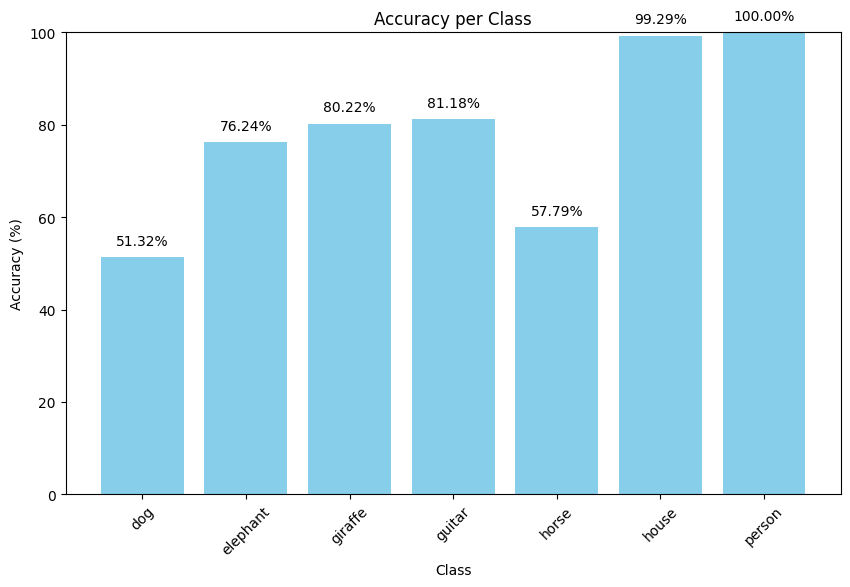

In [12]:
from collections import defaultdict

# Define class names and prepare data structures for storing results
class_names = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
results_by_class = {class_name: [] for class_name in class_names}
class_correct = defaultdict(int)
class_total = defaultdict(int)

# Function to denormalize image for proper visualization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

# Set the model to evaluation mode and run through the test set
model.eval()
with torch.no_grad():
    for inputs, labels in loader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        # Store results and track accuracy for each class
        for img, true_label, pred_label in zip(inputs, labels, predicted):
            true_class = class_names[true_label.item()]
            pred_class = class_names[pred_label.item()]

            # Save image and labels in the dictionary
            results_by_class[true_class].append((img.cpu(), true_class, pred_class))

            # Update accuracy counts
            class_total[true_class] += 1
            if true_label == pred_label:
                class_correct[true_class] += 1

# Calculate accuracy for each class
class_accuracies = {class_name: 100 * class_correct[class_name] / class_total[class_name] 
                    for class_name in class_names}

# Plot the accuracy for each class with percentage labels
plt.figure(figsize=(10, 6))
bars = plt.bar(class_accuracies.keys(), class_accuracies.values(), color='skyblue')
plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

# Add accuracy percentage above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position: middle of the bar
        height + 2,                         # Y position: slightly above the bar
        f'{height:.2f}%',                   # Text with 2 decimal points
        ha='center', va='bottom'            # Center the text horizontally
    )

plt.show()

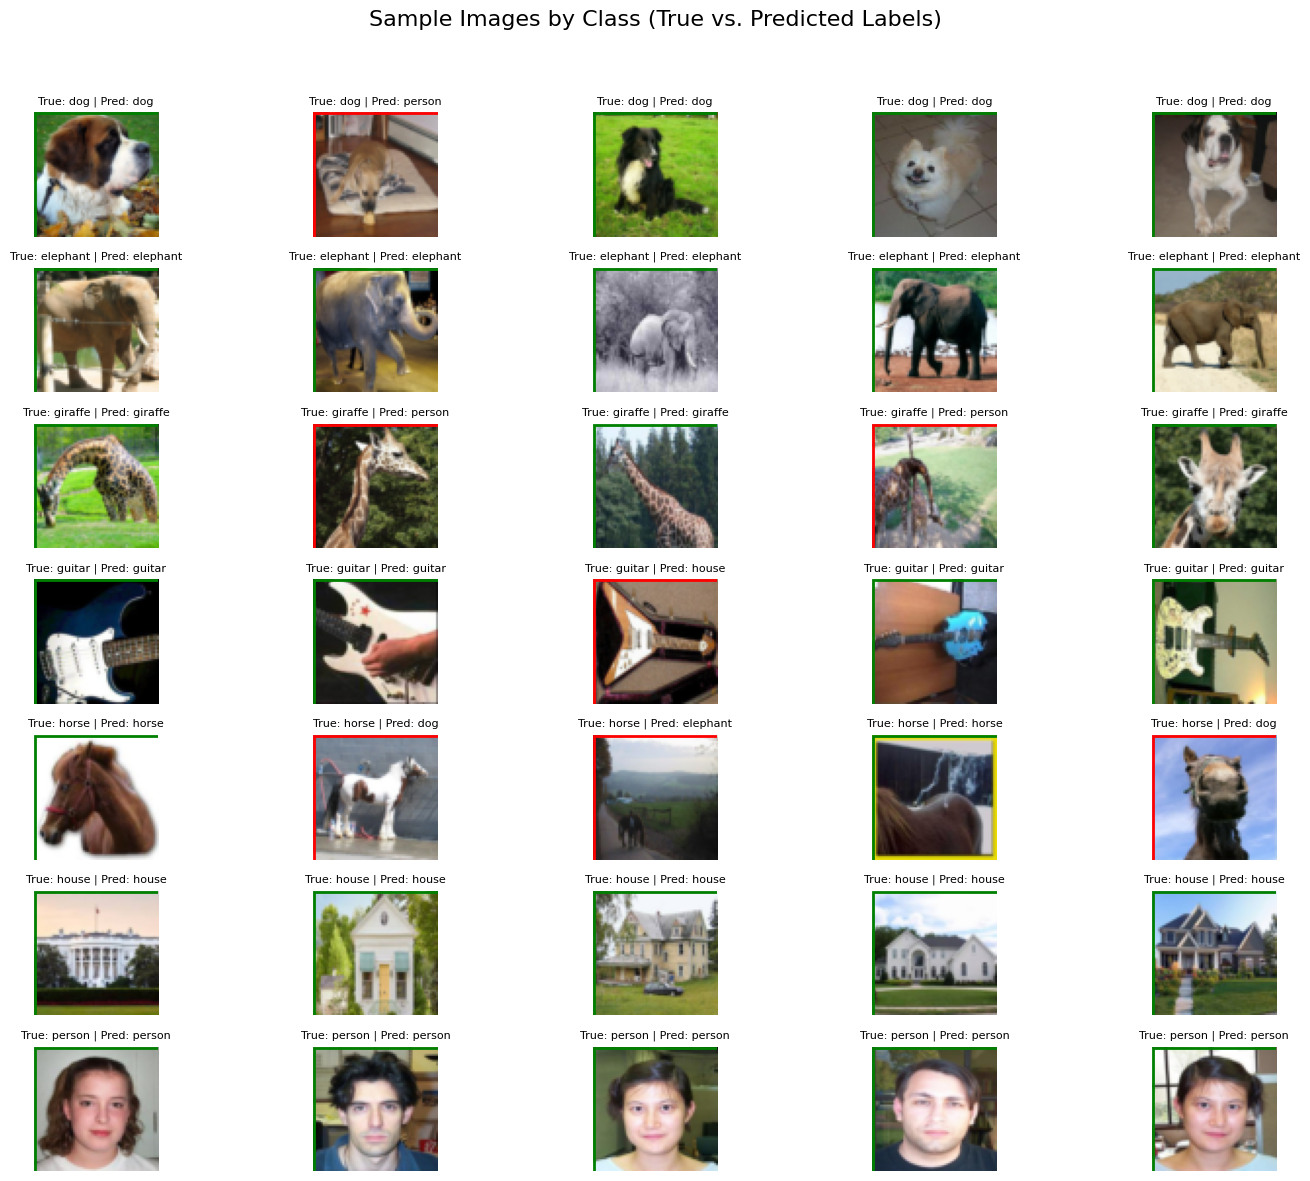

In [13]:
import matplotlib.patches as patches

# Display images with true and predicted labels by class
max_examples_per_class = 5  # Limit the number of images displayed per class
plt.figure(figsize=(15, 12))

# Iterate over each class to display images in the original order
for class_index, (class_name, results) in enumerate(results_by_class.items()):
    # Display up to 'max_examples_per_class' images per class
    for i in range(min(max_examples_per_class, len(results))):
        img, true_class, pred_class = results[i]
        
        # Denormalize the image for display
        img = denormalize(img).numpy().transpose(1, 2, 0)
        img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1] range

        # Plot the image in the grid
        ax = plt.subplot(len(results_by_class), max_examples_per_class, class_index * max_examples_per_class + i + 1)
        ax.imshow(img)
        ax.set_title(f'True: {true_class} | Pred: {pred_class}', fontsize=8)
        ax.axis('off')
        
        # Add green border if correct, red border if incorrect
        color = 'green' if true_class == pred_class else 'red'
        # Create a rectangle around the image
        rect = patches.Rectangle((0, 0), img.shape[1], img.shape[0], linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

plt.suptitle('Sample Images by Class (True vs. Predicted Labels)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
# Test code - DO NOT RUN, and DO NOT MODIFY.
# TAs will evaluate your model using their curated dataset.
if TEST_MODE:
	del model
	model = models.resnet50()
	model.load_state_dict(torch.load(f'./{model_name}'))
	
	root_dir_test = '/work/datasets/CuratedPACS'

	class CustomDataset(Dataset):
		def __init__(self, root_dir, transform=None):
			self.root_dir = root_dir
			self.transform = transform
			self.images = []
			self.labels = []
			self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
			self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
			for cls_name in self.class_to_idx.keys:
				cls_dir = os.path.join(self.root_dir, cls_name)
				for img_name in os.listdir(cls_dir):
					self.images.append(os.path.join(cls_dir, img_name))
					self.labels.append(self.class_to_idx[cls_name])
			
		def __len__(self):
			return len(self.images)

	dataset_test = CustomDataset(root_dir, transform=transform_test)

	# Peform test with the test dataset
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in loader_test:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

	print(f'Test Accuracy: {100 * correct / total:.2f}%')